# The NLP Jounrney
<img src="../assets/banner_notebook_1.jpg">


The NLP domain wasn't always this buzzing with __attention__ and hype that we see today. 
The recent progress in this field is built on top of years of amazing work and research. Before we leap onto the current state of things, let us have a quick walk through of how we arrived here. The current NLP systems are standing tall and promising on the shoulders of very solid work from past decades


## Import Required Libraries

<a target="_blank" href="https://colab.research.google.com/github/raghavbali/llm_workshop/blob/main/module_01/solutions/02_getting_started.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import torch
import torchtext
import os
import collections
import pandas as pd
import numpy as np
import re

In [2]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raghavbali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raghavbali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Get Text
__The Gutenberg Project__ is an amazing project aimed at providing free access to some of the world's most amazing classical works. This makes it a wonderful source of textual data for NLP practitionars to use and improve their understanding of textual data. Ofcourse you can improve your litrary skills too 

For this module and workshop in general we will make use of materials available from the project. We begin by downloading the book __"The Adventures of Sherlock Holmes by Arthur Conan Doyle"__


<img src="../assets/img_2_notebook_1.jpg">

In [3]:
!wget -O sherlock_homes.txt http://www.gutenberg.org/files/1661/1661-0.txt

--2024-07-27 14:34:06--  http://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 2610:28:3090:3000:0:bad:cafe:47, 152.19.134.47
Connecting to www.gutenberg.org (www.gutenberg.org)|2610:28:3090:3000:0:bad:cafe:47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/1661/1661-0.txt [following]
--2024-07-27 14:34:06--  https://www.gutenberg.org/files/1661/1661-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|2610:28:3090:3000:0:bad:cafe:47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607504 (593K) [text/plain]
Saving to: ‘sherlock_homes.txt’

sherlock_homes.txt  100%[===================>] 593.27K  1.18MB/s    in 0.5s    

2024-07-27 14:34:07 (1.18 MB/s) - ‘sherlock_homes.txt’ saved [607504/607504]



### Load Data

In [4]:
filename = "sherlock_homes.txt"
file_text = open(filename, 'r', encoding='utf-8').read()

# lower case text to reduce dimensionality
file_text = file_text.lower() #TODO

# We remove first 1450 characters to remove
# details related to project gutenberg
raw_text = file_text [1450:]

### Text Representation

Feature Engineering is often known as the secret sauce to creating superior and better performing machine learning models. Just one excellent feature could be your ticket to winning a Kaggle challenge! The importance of feature engineering is even more important for unstructured, textual data because we need to convert free flowing text into some numeric representations which can then be understood by machine learning algorithms.

Since text is mostly available in unstructured form yet very high in dimensionality (how??? :sweat: ), the ability to represent text in the most appropriate way is one of the key ingredients to work in this domain.


Let us understand the current dataset at hand by checking the obvious aspects of a textual dataset

In [5]:
# unique list of characters and total characters in the file
char_vocab = sorted(set(raw_text))


# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(char_vocab)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  579975
Total Vocab:  68


### Tokenize and Vectorize
To leverage different algorithms we convert text into numbers that can be represented as tensors.

The first step is to convert text to tokens - tokenization. If we use word-level representation, each word would be represented by its own token. We will use build-in tokenizer from torchtext module

In [6]:
import torchtext; torchtext.disable_torchtext_deprecation_warning()

In [7]:
# Deprecation notice!
from torchtext.data import get_tokenizer
from torchtext.vocab import Vocab

In [8]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [9]:
tokens = tokenizer(raw_text[:50])
print(f'\Token list:\n{tokens}')

\Token list:
['a', 'scandal', 'in', 'bohemia', 'i', '.', 'to', 'sherlock', 'holmes', 'she']


Now, to convert text to numbers, we will need to build a vocabulary of all tokens.

In [10]:
# word level vocab
word_counter = collections.Counter()
for line in raw_text.split('\n'):
    word_counter.update(tokenizer(line))
word_vocab = torchtext.vocab.Vocab(word_counter)

In [11]:
# sample lookup at word-level
word_lookup = [list((word_vocab[w], w)) for w in tokens]
print(f'\nIndex lockup of words in sample sentence:\n{word_lookup}') #TODO


Index lockup of words in sample sentence:
[[2653, 'a'], [12, 'scandal'], [1793, 'in'], [11, 'bohemia'], [2601, 'i'], [6413, '.'], [2742, 'to'], [96, 'sherlock'], [437, 'holmes'], [412, 'she']]


In [12]:
# character level vocab
char2idx = {u:i for i, u in enumerate(char_vocab)}
idx2char = np.array(char_vocab)

text_as_int = np.array([char2idx[c] for c in raw_text])

In [13]:
# char level mapping
print('{')
for char,_ in zip(char2idx, range(10)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '%' :   4,
  '&' :   5,
  '(' :   6,
  ')' :   7,
  '*' :   8,
  ',' :   9,
  ...
}


### Text as Vector

``torchtext`` ``vocab.stoi`` dictionary allows us to convert from a string representation into numbers (``stoi`` -> "from string to integers).

To convert the text back from a numeric representation into text, we can use the ``vocab.itos`` dictionary to perform reverse lookup:

In [14]:
word_vocab_size = len(word_vocab)
print(f"Word Vocab size= {word_vocab_size}")


def encode(x):
    return [word_vocab[s] for s in tokenizer(x)]

vec = encode(raw_text[:100])
print(vec)

Word Vocab size= 9235
[2653, 12, 1793, 11, 2601, 6413, 2742, 96, 437, 412, 1123, 57, 3, 59, 6413, 2601, 916, 6, 113, 433, 634]


### Bag Of Words Representation

Bag of Words (BoW) representation is a traditional vector representation of text for NLP tasks. Each word/character is linked to a vector index, vector element contains the number of occurrences of a word/character in a given document.


In [15]:
def to_bow(text,bow_vocab_size=word_vocab_size):
    res = torch.zeros(bow_vocab_size,dtype=torch.float32)
    for i in encode(text):
        if i<bow_vocab_size:
            res[i] += 1
    return res

In [16]:
sample_text = "this is a sample text to showcase text representation"
print(f"sample text:\n{raw_text[100:150]}")
print(f"\nBoW vector:\n{to_bow(raw_text[100:150])}") # TODO

sample text:
ntion her under any other name. in his eyes she ec

BoW vector:
tensor([2., 0., 0.,  ..., 0., 0., 0.])


### TF-IDF

TF-IDF stands for term frequency–inverse document frequency. It is a form of bag of words representation, where instead of a **binary value** indicating the appearance of a word in a document, a floating-point value is used, which is related to the frequency of word occurrence in the corpus.

The formula to calculate TF-IDF is:

$w_{ij}=tf_{ij}* \log(\frac{N}{df_i})$

Where:

- $i$ is the word
- $j$ is the document
- $w_{ij}$ is the weight or the importance of the word in the document
- $tf_{ij}$ is the number of occurrences of the word i in the document j, i.e. the BoW value we have seen before
- $N$ is the number of documents in the collection
- $df_i$ is the number of documents containing the word i in the whole collection.


TF-IDF value $w_{ij}$ increases proportionally to the number of times a word appears in a document and is offset by the number of documents in the corpus that contains the word, which helps to adjust for the fact that some words appear more frequently than others. For example, if the word appears in every document in the collection, $df_i=N$, and $w_{ij}=0$, and those terms would be completely disregarded.

Let's compute document frequency for each word to start with.
We can represent it as tensor of size vocab_size. We will limit the number of documents to N=1000 to speed up processing. For each input sentence, we compute the set of words (represented by their numbers), and increase the corresponding counter:

In [17]:
raw_text_lines = raw_text.split('\n')
raw_text_lines = [line for line in raw_text_lines if line not in [' ','']]

In [18]:
raw_text_lines[3]

'mention her under any other name. in his eyes she eclipses and'

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(raw_text[:2000].split('\n'))

In [20]:
vectorizer.transform([raw_text_lines[3]]).todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.16078921, 0.29678408, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.33104521, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.33104521, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

### Word Embeddings
A word embedding is a learned dense representation of text. In this approach we represent words and documents as dense vectors that have distinct lexical properties. This can be considered as one of the key breakthroughs in the fielf of NLP.

Let us briefly:

- Understand the Word2Vec models called Skipgram and CBOW

### Word2Vec

This model was created by [Mikolov et. al at Google in 2013](https://arxiv.org/abs/1301.3781). It is a predictive deep learning model designed to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can be trained on massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include,

- The Continuous Bag of Words (CBOW) Model
- The Skip-gram Model

## Continuous Bag of Words (CBOW) Model
The CBOW model architecture tries to predict the current __`target word`__ (the center word) based on the __`source context words`__ (surrounding words).

Considering a simple sentence, “the quick brown fox jumps over the lazy dog”, this can be pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like __([quick, fox], brown)__, __([the, brown], quick)__, __([the, dog], lazy)__ and so on.

Thus the model tries to predict the target_word based on the context_window words.

<img src="../assets/cbow_arch_notebook_1.png">

### Skip-gram Model
The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the __`source context words`__ (surrounding words) given a __`target word`__ (the center word).

Considering our simple sentence from earlier, “the quick brown fox jumps over the lazy dog”. If we used the CBOW model, we get pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like __([quick, fox], brown)__, __([the, brown], quick)__, __([the, dog], lazy)__ and so on.

Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. Hence the task becomes to predict the context [quick, fox] given target word ‘brown’ or [the, brown] given target word ‘quick’ and so on.

Thus the model tries to predict the context_window words based on the target_word.

<img src="../assets/skipgram_arch_notebook_1.png">

In [21]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'
]

In [22]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens) #TODO
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

## Gensim Framework

The ``gensim`` framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the __Word2Vec__ model. We will leverage the same on our sample toy corpus. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.

- vector_size: The word embedding dimensionality
- window: The context window size
- min_count: The minimum word count
- sample: The downsample setting for frequent words
- sg: Training model, 1 for skip-gram otherwise CBOW

We will build a simple Word2Vec model on the corpus and visualize the embeddings.

In [23]:
from gensim.models import word2vec

In [24]:
tokenized_corpus = [tokenizer(line) for line in norm_corpus]

# Set values for various parameters
feature_size = 15    # Word vector dimensionality
window_context = 5   # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

w2v_model = word2vec.Word2Vec(tokenized_corpus,
                              vector_size=feature_size,
                              window=window_context,
                              min_count = min_word_count,
                              sg=sg,
                              sample=sample,
                              epochs=5000)
w2v_model

In [25]:
w2v_model.wv['sky']

array([-0.6649523 ,  0.18757157,  1.131496  ,  0.33526886, -0.5713679 ,
       -0.40595096,  0.91428745,  1.1767576 , -0.13541362,  0.688675  ,
        0.66833806,  0.7583636 , -0.5936025 , -0.70269185,  0.14683938],
      dtype=float32)

In [26]:
w2v_model.wv['India'] #TODO

KeyError: "Key 'India' not present"

In [27]:
import scienceplots
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
plt.style.use(['science','ieee','no-latex'])

%matplotlib inline

/Users/raghavbali/.pyenv/versions/3.11.9/envs/datahack/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


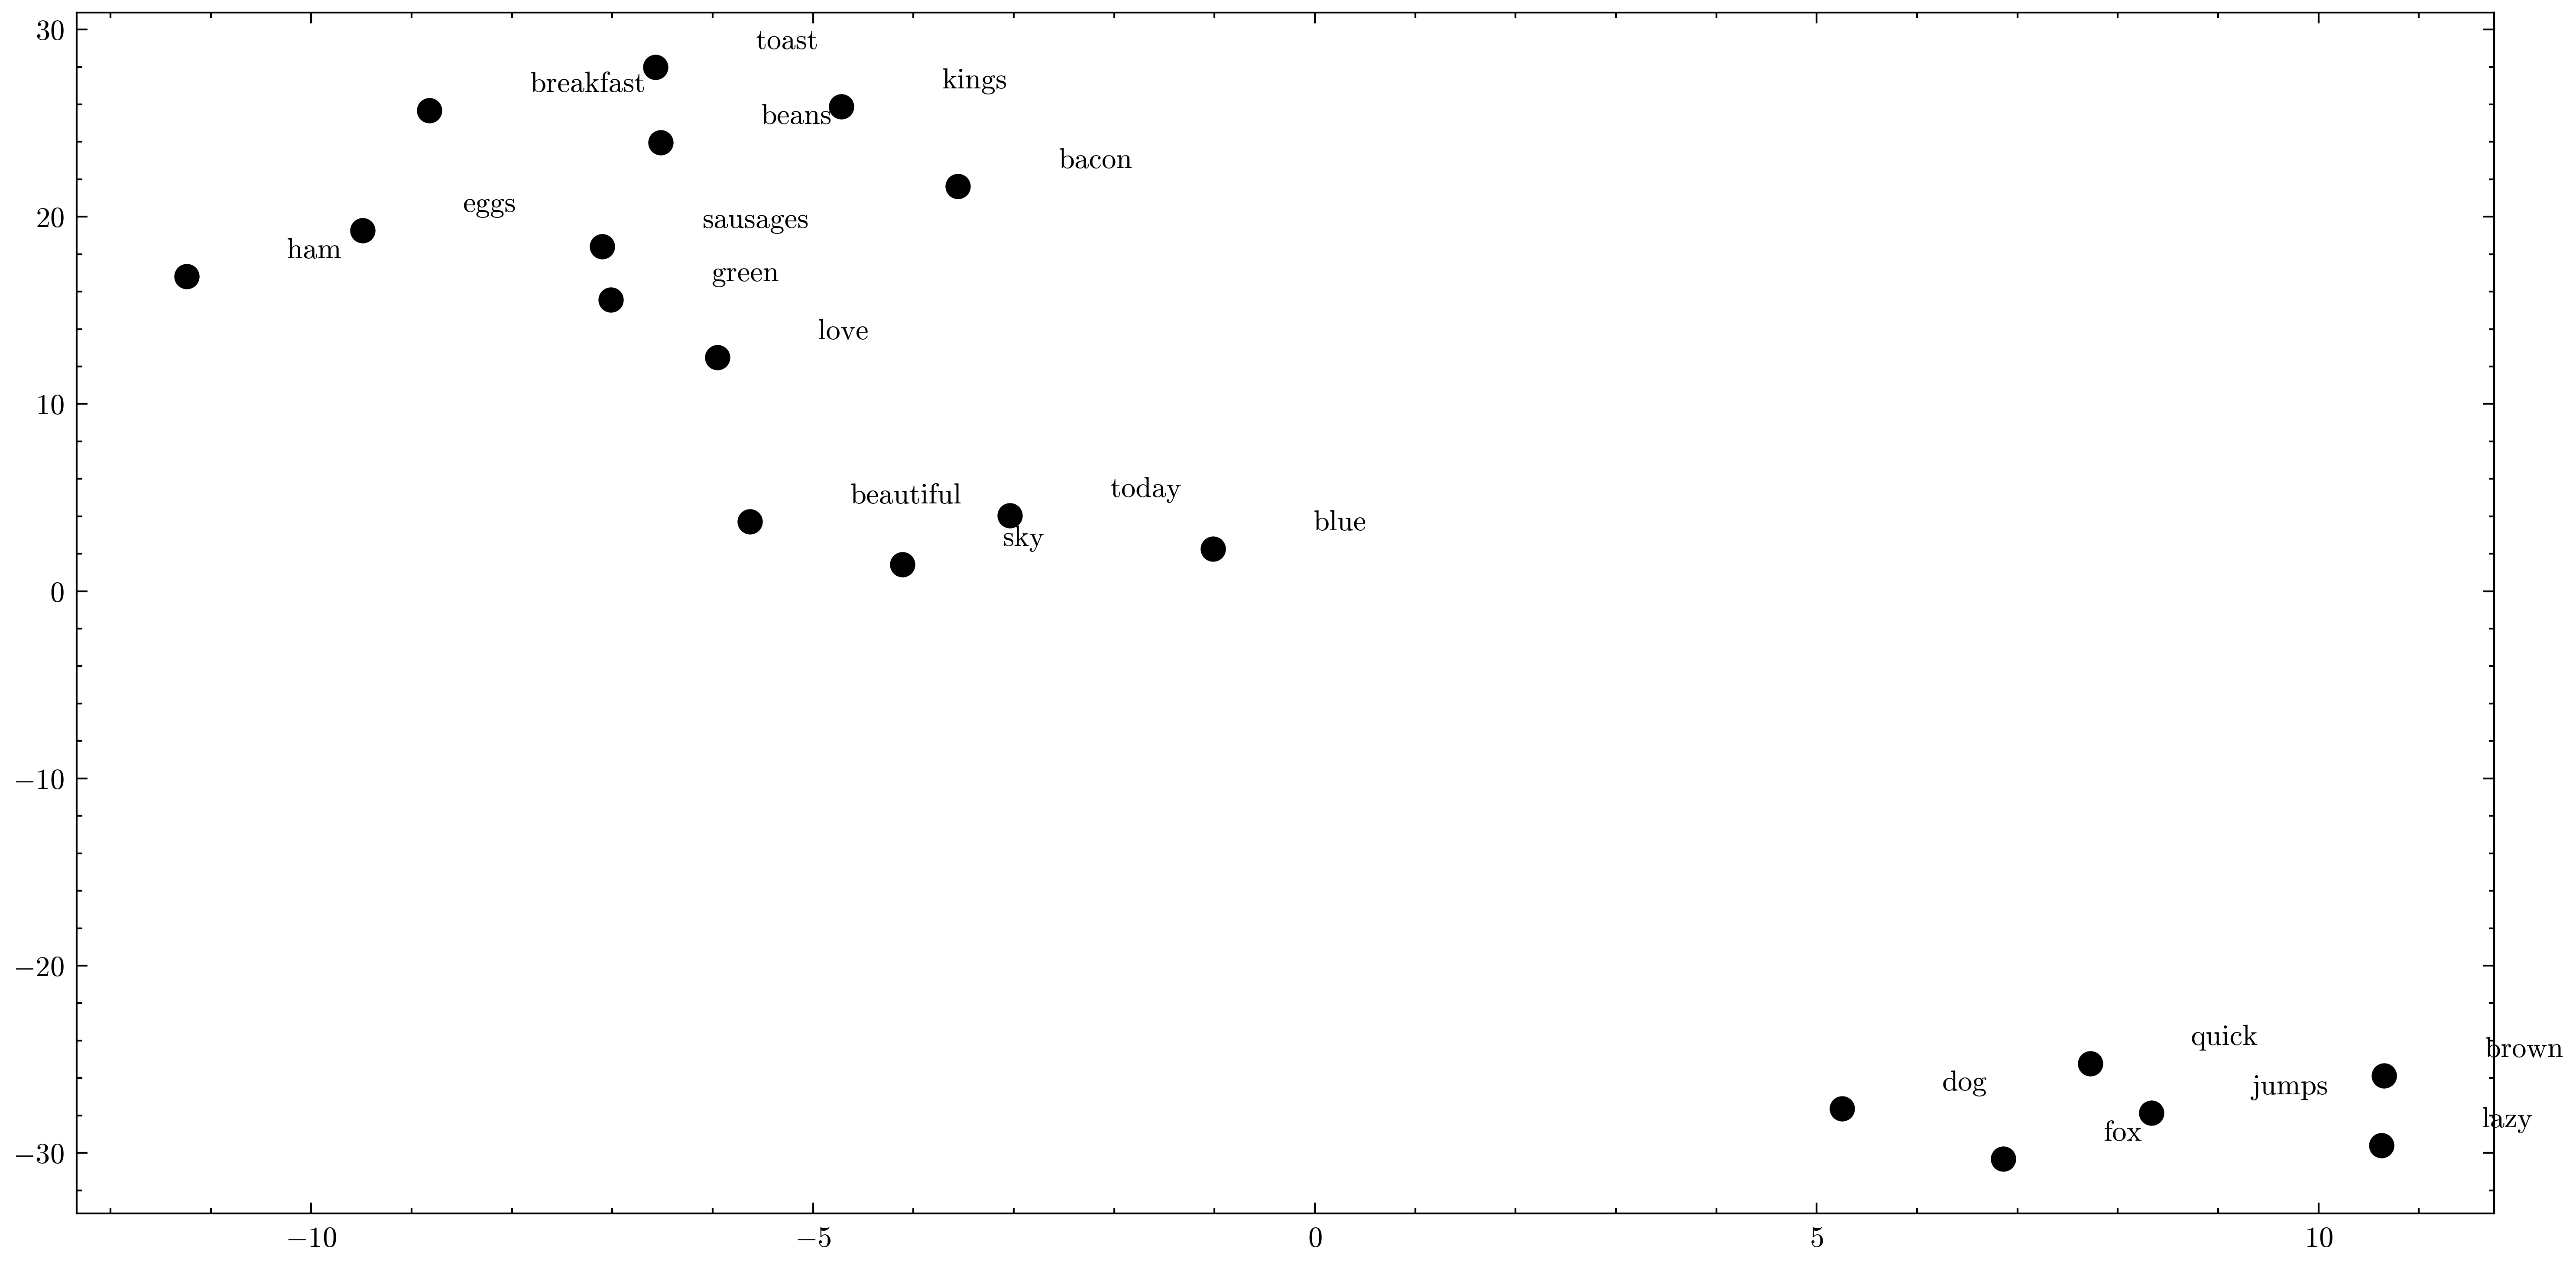

In [28]:
# visualize embeddings
words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1],)
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [29]:
w2v_model.wv.most_similar('breakfast', topn=10)

[('beans', 0.9620550274848938),
 ('toast', 0.951337456703186),
 ('sausages', 0.9320166707038879),
 ('kings', 0.9306779503822327),
 ('eggs', 0.8887607455253601),
 ('bacon', 0.8838085532188416),
 ('green', 0.8683092594146729),
 ('ham', 0.85240238904953),
 ('love', 0.600906491279602),
 ('jumps', 0.26104697585105896)]

## Similar and Improved Works 
- [GloVe](https://nlp.stanford.edu/pubs/glove.pdf)
- [FastText](https://arxiv.org/pdf/1607.04606.pdf)
- [Sent2Vec](https://arxiv.org/abs/1405.4053)
- X2Vec

In [30]:
with open("norm_corpus.txt","w") as f:
    for line in norm_corpus:
        f.write(line+'\n')

In [31]:
import fasttext
fasttext_model = fasttext.train_unsupervised('norm_corpus.txt', model='skipgram',epoch=500000,minCount=1,loss='ns')

Read 0M words
Number of words:  21
Number of labels: 0
Progress: 100.0% words/sec/thread: 1392597 lr:  0.000000 avg.loss:  1.905138 ETA:   0h 0m 0s


In [32]:
fasttext_model.get_word_vector('sky')

array([ 0.09724393,  0.6145639 , -0.24108043, -0.36315957,  0.6147418 ,
        0.57301635,  0.20382696,  0.03375906,  0.22221567,  0.9292169 ,
       -0.05056102,  0.4155957 ,  0.69309413,  0.7699372 , -0.17131692,
       -0.04409195,  0.23795936,  0.38001457, -0.09292803, -0.1437447 ,
        0.08828843, -0.10014508, -0.0272089 , -0.18043298, -0.02767386,
       -0.49503702, -0.04807977, -0.280645  ,  0.08212067,  0.23278186,
       -0.23208503,  0.07819745, -0.6856505 , -0.3013633 ,  0.06591483,
        0.01730188,  0.16945036,  0.12655948, -0.47412974, -0.14375567,
       -0.16048965,  0.83452904,  0.21553141, -0.07866434, -0.22532359,
        0.2097939 ,  0.12529437,  0.22896571, -0.18486781,  0.03586057,
       -0.56272   ,  0.08174123, -0.22207178,  0.19690703, -0.04614386,
       -0.43608338, -0.33864635, -0.09719773,  0.47601014, -0.00545119,
       -0.2726593 , -0.00116102,  0.29335546,  0.19227633, -0.20841871,
       -0.54498446, -0.3551918 ,  0.29804555,  0.26118392, -0.04

In [33]:
fasttext_model.get_word_vector('India') # TODO

array([ 0.00017626,  0.00129561, -0.00194463, -0.00104311, -0.00261798,
       -0.00138431,  0.00178319, -0.00017682,  0.00074101, -0.00024207,
       -0.00025072,  0.00039339,  0.00128912, -0.00016941,  0.00050951,
        0.0003814 ,  0.00030132,  0.00210252,  0.00030496, -0.00026221,
       -0.00014151, -0.00213423, -0.00082267,  0.00002159,  0.00254331,
       -0.00071717,  0.00160617,  0.00049344,  0.00168671,  0.0006019 ,
        0.00375156,  0.00095259, -0.00003995, -0.00027063,  0.00096187,
        0.0003007 , -0.00312283, -0.00183586, -0.00044985, -0.00119078,
       -0.00122052, -0.00096989, -0.00087144, -0.0010528 ,  0.0013532 ,
       -0.00190088,  0.00068051,  0.00117384,  0.00229423,  0.00075331,
        0.00004409, -0.00140234,  0.0030936 , -0.00315117,  0.00102672,
       -0.00077691, -0.00206126,  0.00097643, -0.00226257, -0.00204253,
        0.00151282,  0.00050916, -0.0007809 , -0.00073181, -0.00287193,
        0.00144253,  0.00012878, -0.00109363, -0.00016039, -0.00

In [34]:
fasttext_model.get_nearest_neighbors('breakfast')

[(0.544626772403717, 'beans'),
 (0.5437572002410889, 'toast'),
 (0.5114316344261169, 'kings'),
 (0.42740651965141296, 'ham'),
 (0.4264087975025177, 'eggs'),
 (0.4211324155330658, 'sausages'),
 (0.3930533826351166, 'bacon'),
 (0.36361247301101685, 'green'),
 (0.25671836733818054, 'love'),
 (0.19147588312625885, 'brown')]

### Limitations
One key limitation of traditional pretrained embedding representations such as Word2Vec is the problem of word sense and removing ambiguity by making them clear. While pretrained embeddings can capture some of the meaning of words in context, every possible meaning of a word is encoded into the same embedding. This can cause problems in downstream models, since many words such as the word 'play' have different meanings depending on the context they are used in.

For example, the word 'play' in these two different sentences have quite different meaning:

- I went to a **play** at the theatre.
- John wants to **play** with his friends.
The pretrained embeddings above represent both meanings of the word 'play' in the same embedding. To overcome this limitation, we need to build embeddings based on the language model, which is trained on a large corpus of text, and knows how words can be put together in different contexts.